In [121]:
import pandas as pd
import os
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [122]:
os.chdir("E:\Insofe\PH.D\PHD_ML")

In [123]:
ratings = pd.read_csv("user_hotel_rating-1555730075105.csv")

In [124]:
ratings.head()

,userid,Hotelid,OverallRating
0,user_78131,hotel_558,3
1,user_78131,hotel_603,2
2,user_78131,hotel_610,3
3,user_78131,hotel_574,3
4,user_78131,hotel_570,3


In [125]:
df = ratings

In [126]:
Ratings1 = pd.read_csv("Ratings1.csv")

In [127]:
ratings.shape

(271935, 3)

In [128]:
preds.shape

(52587, 5)

In [129]:
Ratings1.head(3)

,Row_no,userid,501,502,503,504,506,507,508,509,...,630,631,632,633,634,635,636,637,639,640
0,1,21002,0,3,0,3,3,0,4,0,...,4,0,0,3,0,0,0,3,0,0
1,2,21025,0,0,0,2,0,0,0,3,...,0,2,0,0,4,2,0,0,3,3
2,3,21042,0,0,0,0,4,0,3,0,...,0,0,2,0,0,0,2,0,2,0


In [130]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (271935, 3)
-Dataset examples-
            userid    Hotelid  OverallRating
0       user_78131  hotel_558              3
200000  user_59965  hotel_622              2


# EDA
Ratings Distribution

In [131]:
import plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['OverallRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} hotel-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# Ratings Distribution By Hotel

In [132]:
# Number of ratings per book
data = df.groupby('Hotelid')['OverallRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 51.5,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Hotel (Clipped at 51.5)',
                   xaxis = dict(title = 'Number of Ratings Per Hotel'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [133]:

df.groupby('Hotelid')['OverallRating'].count().reset_index().sort_values('OverallRating', ascending=False)[:10]

,Hotelid,OverallRating
99,hotel_608,2489
50,hotel_557,2487
49,hotel_555,2487
47,hotel_552,2487
110,hotel_620,2487
120,hotel_630,2487
98,hotel_607,2485
123,hotel_633,2482
66,hotel_573,2478
78,hotel_585,2473


Most of the books received less than 5 ratings, and few hotels have many ratings, although the most rated book has received 2,489 rating

# Ratings Distribution By Hotel


In [134]:
# Number of ratings per user
data = df.groupby('userid')['OverallRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 10000,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 10000)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [135]:
df.groupby('userid')['OverallRating'].count().reset_index().sort_values('OverallRating', ascending=False)[:10]


,userid,OverallRating
1324,user_42069,69
3348,user_60087,67
2922,user_56548,67
3366,user_60192,65
3505,user_61675,64
3556,user_62237,64
3559,user_62269,64
2042,user_49035,64
1422,user_43213,64
3496,user_61499,64


# Most of the users gave less than 5 ratings, and very few users gave many ratings, although the most productive user have given 69 ratings.

I'm sure you have noticed that the above two charts share the same distribution. The number of ratings per Hotel and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users.

In [136]:
min_hotel_ratings = 50
filter_hotels = df['Hotelid'].value_counts() > min_hotel_ratings
filter_hotels = filter_hotels[filter_hotels].index.tolist()

min_user_ratings = 50
filter_users = df['userid'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['Hotelid'].isin(filter_hotels)) & (df['userid'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(271935, 3)
The new data frame shape:	(210346, 3)


# Surprise
To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [137]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_new[['userid', 'Hotelid', 'OverallRating']], reader)

C:\Users\prash\Anaconda3\lib\site-packages\scikit_surprise-1.0.6-py3.6-win-amd64.egg\surprise\dataset.py:61: UserWarning:

Using rating_scale from reader, deprecated. Set rating_scale at dataset creationg instead (load_from_file, load_from_folds, or load_from_df).



In [138]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [139]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')


In [140]:
surprise_results


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.837144,10.145881,53.330379
KNNWithZScore,0.837202,10.734248,62.827211
KNNWithMeans,0.837305,10.385239,56.212366
SVD,0.839884,6.678129,0.411899
CoClustering,0.850215,3.180341,0.424389
KNNBasic,0.853471,9.732946,55.159841
BaselineOnly,0.857021,0.366653,0.325503


KNNWithZScore algorithm gave us the best rmse, therefore, we will proceed further with KNNWithZScore and use Alternating Least Squares (ALS).

In [141]:

print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = KNNWithZScore(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.83894716, 0.8368146 , 0.83607864]),
 'fit_time': (10.178803205490112, 10.421097040176392, 10.086728811264038),
 'test_time': (54.42060995101929, 55.883569955825806, 54.17111682891846)}


We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [144]:

trainset, testset = train_test_split(data, test_size=0.25)
algo = KNNWithZScore(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8304


0.8303774392028219

In [145]:
# dump.dump('./dump_file', predictions, algo)
# predictions, algo = dump.load('./dump_file')

In [146]:
trainset = algo.trainset
print(algo.__class__.__name__)

KNNWithZScore


In [323]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['userid', 'Hotelid', 'OverallRating', 'Predictions', 'details'])
df['Iu'] = df.userid.apply(get_Iu)
df['Ui'] = df.Hotelid.apply(get_Ui)
df['err'] = abs(df.Predictions - df.OverallRating)

In [149]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [150]:
best_predictions

,userid,Hotelid,OverallRating,Predictions,details,Iu,Ui,err
22234,user_63425,hotel_611,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",44,1288,0.0
20466,user_40958,hotel_618,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",50,1374,0.0
9640,user_67373,hotel_546,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",53,1340,0.0
21547,user_26878,hotel_598,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",40,1340,0.0
14980,user_26357,hotel_534,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",37,1299,0.0
40954,user_64566,hotel_548,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",40,1249,0.0
9742,user_71384,hotel_601,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",46,1361,0.0
16695,user_53132,hotel_598,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",47,1340,0.0
46376,user_26792,hotel_636,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",40,1361,0.0
24426,user_71287,hotel_622,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",39,1315,0.0


The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 1307 to 1387, they are not really small, meaning that significant number of users have rated the target Hotel.

In [151]:
worst_predictions


,userid,Hotelid,OverallRating,Predictions,details,Iu,Ui,err
47942,user_62174,hotel_577,1.0,4.782275,"{'actual_k': 40, 'was_impossible': False}",42,1305,3.782275
18585,user_50107,hotel_626,5.0,1.213479,"{'actual_k': 40, 'was_impossible': False}",38,1360,3.786521
5000,user_76195,hotel_566,5.0,1.210732,"{'actual_k': 40, 'was_impossible': False}",38,1357,3.789268
45784,user_76195,hotel_623,5.0,1.208961,"{'actual_k': 40, 'was_impossible': False}",38,1377,3.791039
1547,user_64311,hotel_626,1.0,4.800337,"{'actual_k': 40, 'was_impossible': False}",43,1360,3.800337
2179,user_70646,hotel_615,5.0,1.177150,"{'actual_k': 40, 'was_impossible': False}",41,1287,3.822850
5145,user_59260,hotel_597,1.0,4.870546,"{'actual_k': 40, 'was_impossible': False}",37,1198,3.870546
48854,user_44829,hotel_552,5.0,1.078334,"{'actual_k': 40, 'was_impossible': False}",38,1400,3.921666
41658,user_26878,hotel_523,1.0,5.000000,"{'actual_k': 40, 'was_impossible': False}",40,1309,4.000000
15358,user_49282,hotel_543,5.0,0.904601,"{'actual_k': 40, 'was_impossible': False}",43,1158,4.095399


The worst predictions look pretty surprise. Let's look in more details of the last one Hotel "hotel_548", the hotel was rated by 1298 users, user "65896" rated 5, our KNNWithZScore algorithm predicts 0.95.

In [152]:
df_new.loc[df_new['Hotelid'] == 'hotel_548']['OverallRating'].describe()

count    1701.000000
mean        2.905350
std         1.090537
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: OverallRating, dtype: float64

<IPython.core.display.Javascript object>


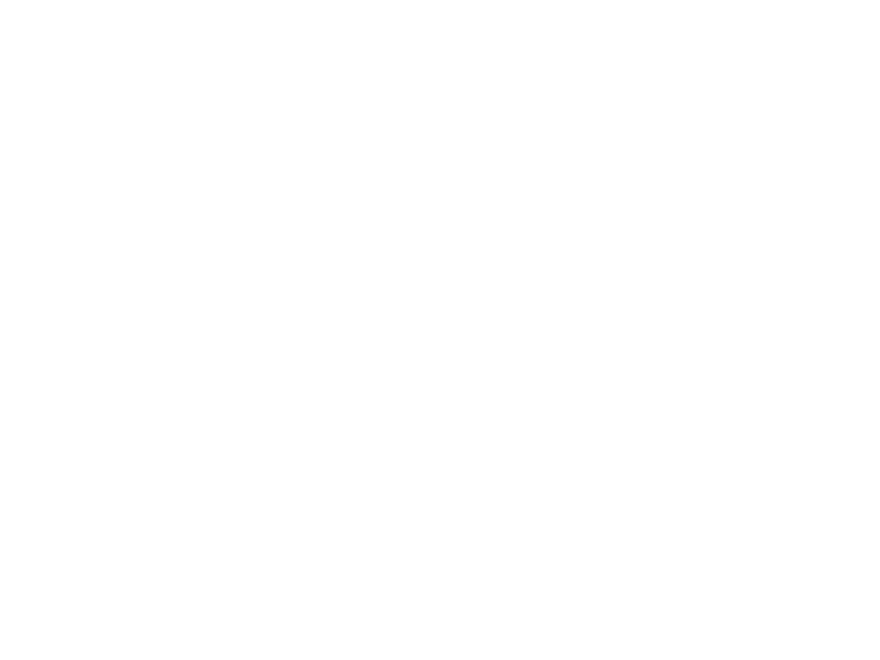

In [153]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['Hotelid'] == 'hotel_548']['OverallRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings hotel hotel_548 has received')
plt.show();

In [ ]:
It turns out, most of the ratings this hotel received was "3", in another word, most of the users in the data rated this book "0", only very few users rated "5". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.